**Import libs**

In [ ]:
from typing import List, Dict, Set, Tuple, Callable
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

**Import torch related libs**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Make a data directory**

In [ ]:
!mkdir -p dataset/CIFAR10/{training,testing}
!mkdir -p model

**Global variables (If Any)**

In [ ]:
paths = defaultdict(lambda: "")
paths["training_data"] = "/content/dataset/CIFAR10/training/"
paths["testing_data"] = "/content/dataset/CIFAR10/testing/"
paths["model_dir"] = "/content/model/"

In [ ]:
lables = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Download Training and Testing Data**

In [ ]:
training_transforms = transforms.Compose([transforms.ToTensor()])
training_data = datasets.CIFAR10(root=paths["training_data"], train=True, download=True, transform=training_transforms)
testing_transforms = transforms.Compose([transforms.ToTensor()])
testing_data = datasets.CIFAR10(root=paths["testing_data"], train=False, download=True, transform=testing_transforms)

Extracting /content/dataset/CIFAR10/training/cifar-10-python.tar.gz to /content/dataset/CIFAR10/training/


Extracting /content/dataset/CIFAR10/testing/cifar-10-python.tar.gz to /content/dataset/CIFAR10/testing/


**Load data to iterators**

In [ ]:
train_set = torch.utils.data.DataLoader(training_data, batch_size=11, shuffle=True)
test_set = torch.utils.data.DataLoader(testing_data, batch_size=11, shuffle=True)

**Show random four images in the training set**

In [ ]:
train_set_iter = iter(train_set)
test_set_iter = iter(test_set)

In [ ]:
def show_images(dataiter: iter, n: int = 4):
    
    x, y = dataiter.next()

    fig, ax = plt.subplots(1, n, facecolor="white")

    for i, img in enumerate(x):
        if i >= n:
            break
        else:
            # convert from CHW to HWC from 3x32x32 to 32x32x3
            img = img.numpy()
            ax[i].imshow(img.transpose(1,2,0))
            ax[i].set_title(lables[y[i]])
            ax[i].set_xticks([])
            ax[i].set_yticks([])

    return

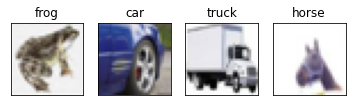

In [ ]:
show_images(train_set_iter)

**Save Model**

In [ ]:
def save_model(model: nn.Module, model_name: str):
    torch.save(model, "{}{}".format(paths["model_dir"], model_name))
    return

**Load Model**

In [ ]:
def load_model(model_name: str):
    model = torch.load("{}{}".format(paths["model_dir"], model_name))
    model.eval()
    return model

**Build Model**

In [ ]:
class CNN(nn.Module):
    def __init__(self):

        # parent init
        super().__init__()

        # self.conv1 = nn.Conv2d(3, 32, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, 10)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        return


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
    def config(self):
        print(self)
        return


In [ ]:
cnn = CNN()
cnn.config()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


**Optimizer**

In [ ]:
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=9e-1)

**Loss Function**

In [ ]:
loss_fn = nn.CrossEntropyLoss()

**Train Model**

In [ ]:
def fit(model: nn.Module, criterion: Callable, epochs: int = 100) -> Tuple:
    running_loss_list = []

    for epoch in trange(epochs):
        

        running_loss = 0

        # Loop through training set
        for n, data in enumerate(train_set):

            # separate images and their lables
            X, y = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # Feed forward
            y_ = model(X)
            loss = criterion(y_, y)

            # back-propogate
            loss.backward()

            # take one step for optimization
            optimizer.step()

            # append loss
            running_loss += loss.item()
        
        running_loss_list.append(running_loss)

        # print loss at every epoch
        print(f"\r loss = {str(running_loss)}",end='')

    print()
    return running_loss_list

In [ ]:
rl_wo_sm = fit(model=cnn, criterion=loss_fn, epochs=10)

 loss = 9130.365531682968



In [ ]:
# cnn_2 = CNN()
# rl_w_sm = fit(model=cnn_2, criterion=loss_fn, epochs=10)

10


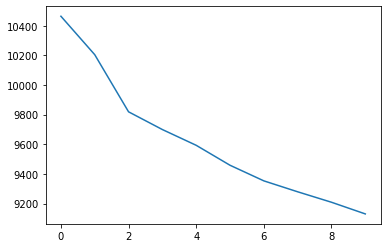

In [ ]:
print(len(rl_wo_sm))
#plt.scatter(x = [x for x in range(len(rl_wo_sm))], y = rl_wo_sm)
plt.plot(rl_wo_sm)
plt.show()

In [ ]:
save_model(cnn, "cnn.pt")

**Evaluate Model**

In [ ]:
def eval(model: nn.Module):
    correct = 0
    total = 0
    
    # Stop gradient updation
    with torch.no_grad():

        # Loop through testing set
        for data in tqdm(test_set, desc="Evaluating"):
            
            # separate images and their lables
            X, y = data
            
            # Get output
            y_ = model(X)

            # Check for all the Ys
            for idx, i in enumerate(y_):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    
    print(f"Accuracy: {str(round(correct/total * 100, 2))}%")
    return


In [ ]:
cnn = load_model("cnn.pt")
eval(cnn)


Accuracy: 46.44%


Doubts

1. Softmax not working
2. How to flatten a layer
3. Can we use same varialbe of again anf again
4. How to print in forward
5. How to manupulate tensors